# Self-Driving Car Engineer Nanodegree


## Project: **Vehicle Detection** 
Vehicle Detection Project
The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Import Packages

In [91]:
#Cell:1 
# Import libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

Step1: Extract HOG features from the training images. Explain final choice of HOG parameters.
Step2: Train a classifier using selected HOG features, Color Histogram features and Spatial Binning of Color 

8792 8968


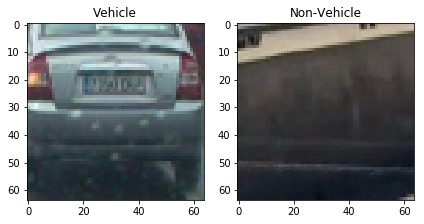

In [92]:
#Cell:2
#Extract Car and NotCar images and show one example
cars = []
notcars = []

images = glob.glob('vehicles/GTI_Far/*.png')
for image in images:
        cars.append(image)
        
images = glob.glob('vehicles/GTI_Left/*.png')
for image in images:
        cars.append(image)
        
images = glob.glob('vehicles/GTI_MiddleClose/*.png')
for image in images:
        cars.append(image)
        
images = glob.glob('vehicles/GTI_Right/*.png')
for image in images:
        cars.append(image)

images = glob.glob('vehicles/KITTI_extracted/*.png')
for image in images:
        cars.append(image)

images = glob.glob('non-vehicles/Extras/*.png')
for image in images:
        notcars.append(image)

images = glob.glob('non-vehicles/GTI/*.png')
for image in images:
        notcars.append(image)

print(len(cars),len(notcars))  

#Example
ind = np.random.randint(0, len(cars))
file = cars[ind]
image = mpimg.imread(file)
fig = plt.figure()
plt.subplot(121)
plt.imshow(image)
plt.title('Vehicle')
file = notcars[ind]
image = mpimg.imread(file)
plt.subplot(122)
plt.imshow(image)
plt.title('Non-Vehicle')
fig.tight_layout()
plt.show()

In [181]:
#Cell:3
#HOG Parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL"# Can be 0, 1, 2, or "ALL"
spatial_size = (32,32)
hist_bins = 32

In [131]:
#Cell:4
def convert_color(img, conv='RGB2YUV'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2GRAY':
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

#Spatial Binning of color    
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.concatenate((color1, color2, color3))

#Color Histograms                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    #print(channel1_hist.shape)
    return hist_features

In [132]:
#Cell:5
# Define a function to extract HOG features from a list of images
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features
    
def extract_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            elif cspace == 'GRAY':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)    
        else: feature_image = np.copy(image)      
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=False))

            hog_features = np.ravel(hog_features)
            
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=False)
            hog_features = np.ravel(hog_features)   
            #features.append(np.array(hog_features))
        
        # Append the new feature vector to the features list
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
        features.append(np.hstack((spatial_features, hist_features, hog_features)))
        
    # Return list of feature vectors
    return features

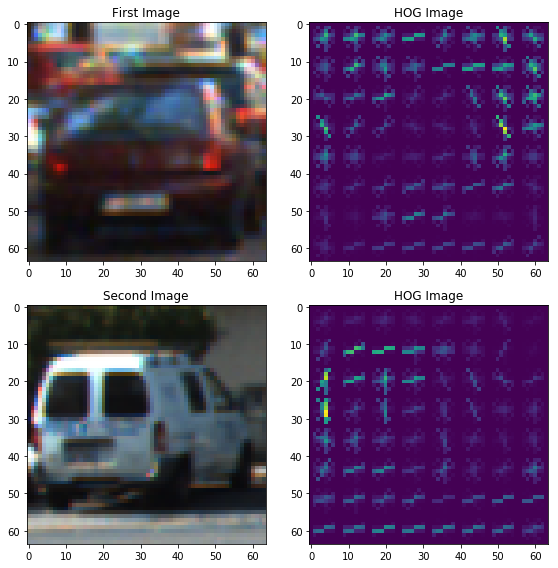

In [205]:
#Cell:6
#HOG Visualisation
car_ind = np.random.randint(0, len(cars))
file = cars[car_ind]
image = mpimg.imread(file)
_, hogimage = get_hog_features(image[:,:,0], 9, 8, 2, vis=True, feature_vec=True)
car_ind = np.random.randint(0, len(cars))
file = cars[car_ind]
image2 = mpimg.imread(file)
_, hogimage2 = get_hog_features(image2[:,:,0], 9, 8, 2, vis=True, feature_vec=True)
f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))
ax1.set_title("First Image",fontsize=12)
ax1.imshow(image)
ax2.set_title("HOG Image",fontsize=12)
ax2.imshow(hogimage)
ax3.set_title("Second Image",fontsize=12)
ax3.imshow(image2)
ax4.set_title("HOG Image",fontsize=12)
ax4.imshow(hogimage2)
f.tight_layout()
plt.show()

In [182]:
#Cell:7
#HOG and Color Features Extraction
t=time.time()
car_features = extract_features(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(len(car_features),len(notcar_features))
print(round(t2-t, 2), 'Seconds to extract features')


8792 8968
86.25 Seconds to extract features


In [183]:
#Cell:8
#Normalize the Features
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64) 
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
print(len(X))
print("done")

17760
done


In [184]:
#Cell:9
#Split data into train and test set
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)
print(len(X_train),len(X_test))

14208 3552


In [185]:
#Cell:10
# Train SVM Classifier and detect test set accuracy
svc = LinearSVC()
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

11.4 Seconds to train SVC...
Test Accuracy of SVC =  0.991


(64, 64, 3)


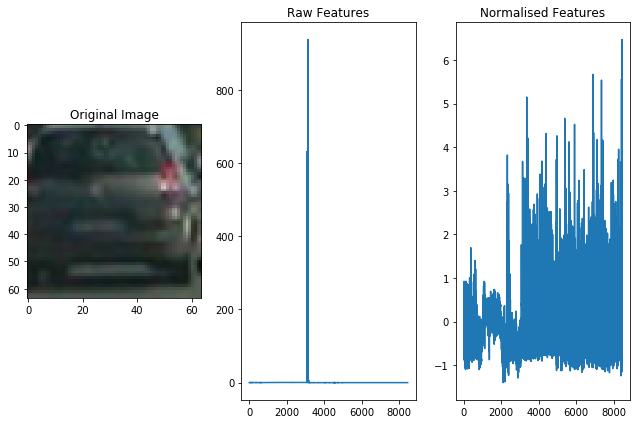

In [187]:
#Cell:11
#Example of Raw and Normalised Feature distribution 
car_ind = np.random.randint(0, len(cars))
file = cars[car_ind]
image = mpimg.imread(file)
print(image.shape)
f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(9,6))
ax1.set_title("Original Image",fontsize=12)
ax1.imshow(image)
ax2.set_title("Raw Features",fontsize=12)
ax2.plot(X[car_ind])
ax3.set_title("Normalised Features",fontsize=12)
ax3.plot(scaled_X[car_ind])
f.tight_layout()
plt.show()

Step3: Implement a sliding window search to classify each overlapping tile as vehicle or non-vehicle
Provide scales to search and percentage of windows overlap.
Step4: Show examples of test images to demonstrate pipeline. Optimise performance of the chosen clasifier. 

In [199]:
#Cell:12
#Sliding Window Implementation
#Use of Color Features and Hog features from test images/frames 
#of video to predict the car and not car type of images

boxes = []
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:] 
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Define blocks and steps as above; 853,170
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    #print(nxblocks,nyblocks,nfeat_per_block)
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    #print(nxsteps,nysteps,nblocks_per_window)

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #print(hog_features.shape)
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch 
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #plt.title("Identified Vehicle Positions by Classifier")
                #plt.imshow(draw_img)
                #plt.show()
    return draw_img,boxes

In [200]:
#Cell:13
#Remove False Positive 
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1.0    # Return updated heatmap
    #plt.figure(figsize=(6,6))
    #plt.imshow(heatmap)
    #plt.show()
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)),(np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        #print(bbox[0],bbox[1])
    # Return the image
    return img

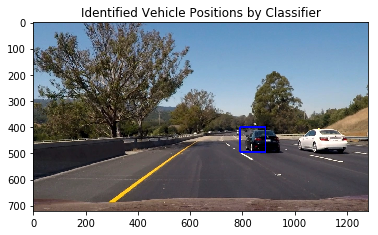

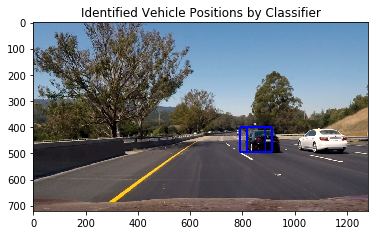

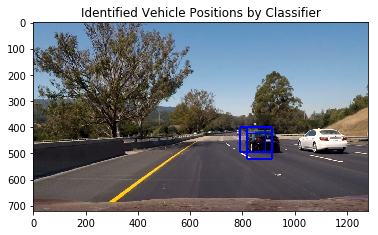

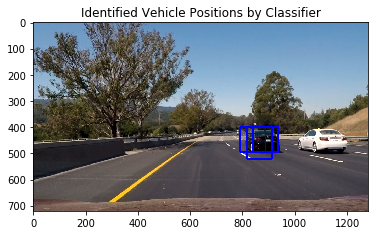

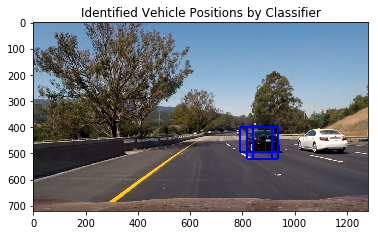

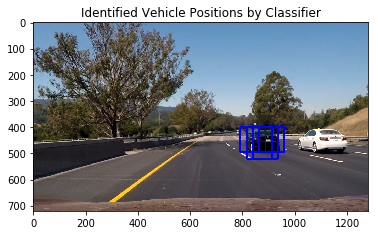

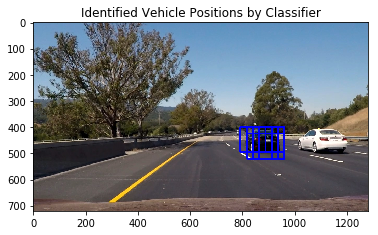

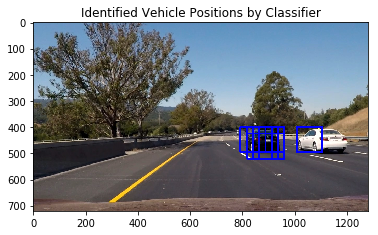

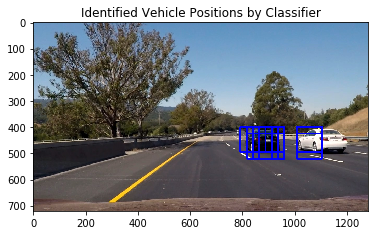

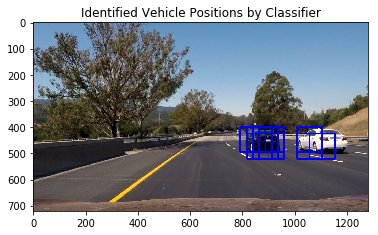

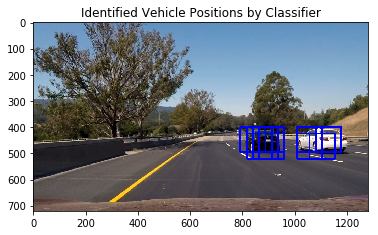

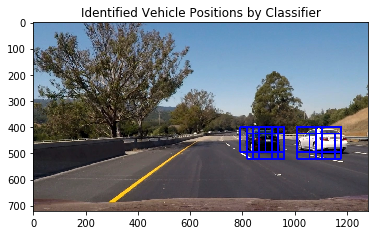

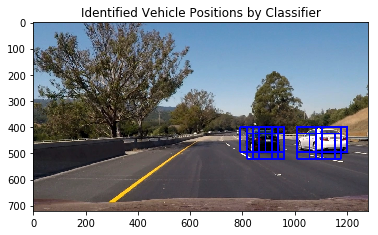

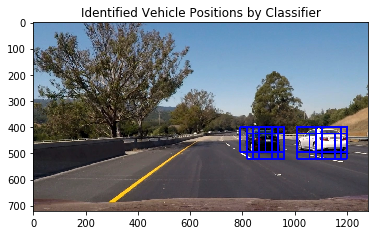

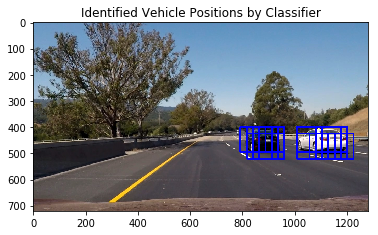

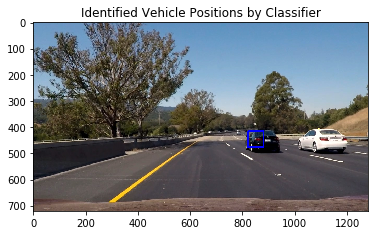

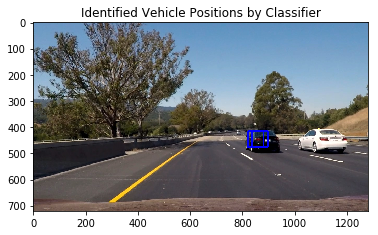

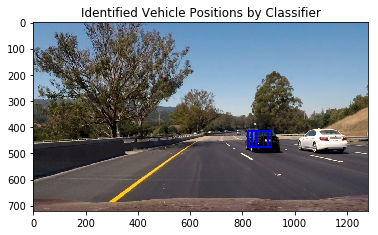

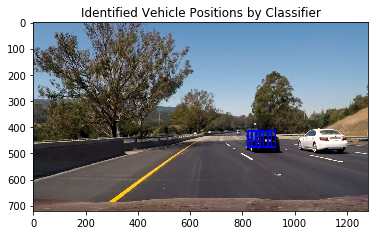

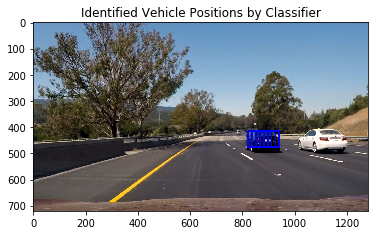

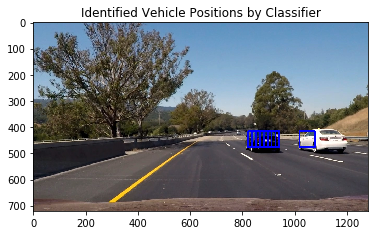

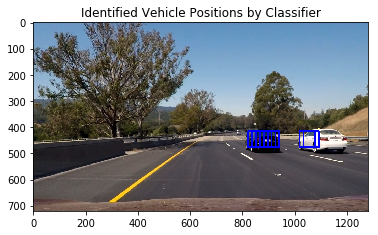

No of final boxes
2
(816, 400) (959, 519)
(1008, 400) (1199, 519)


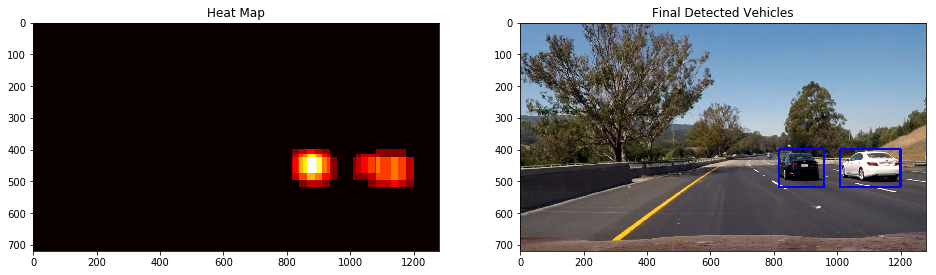

In [193]:
#Cell:14
from scipy.ndimage.measurements import label
images = glob.glob('./test_images/test6.jpg')
for file in images:
    
    boxes[:] = []

    img = mpimg.imread(file)
   
    #For TestImage test3.jpg, following additional scale is required to detect the vehicle
    ystart = 400
    ystop = 700
    scale = 1.5
    out_img,boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins) 
    ystart = 416
    ystop = 480
    scale = 0.95
    out_img,boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins) 
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    heat = add_heat(heat,boxes)  
    
    #add current with previous average heat map
    #heat = heat + sumheat

    heat = apply_threshold(heat, 1)

    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    print("No of final boxes")
    print(labels[1])
    
    draw_img= draw_labeled_bboxes(np.copy(img), labels)

    #saveLastheat(heat)  
    
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
    ax2.imshow(draw_img)
    ax2.set_title('Final Detected Vehicles')
    ax1.imshow(heatmap, cmap='hot')
    ax1.set_title('Heat Map')
    fig.tight_layout()
    plt.show()


No of final boxes
2


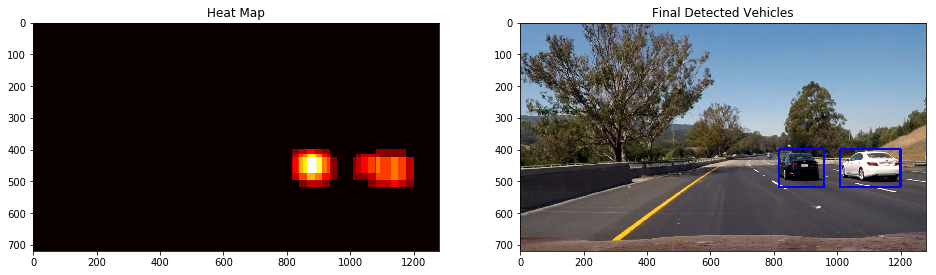

No of final boxes
2


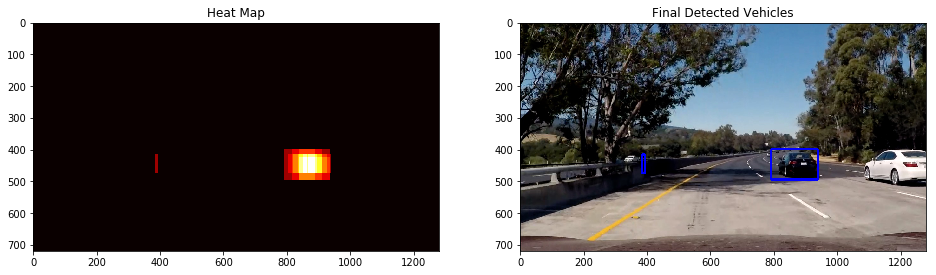

No of final boxes
2


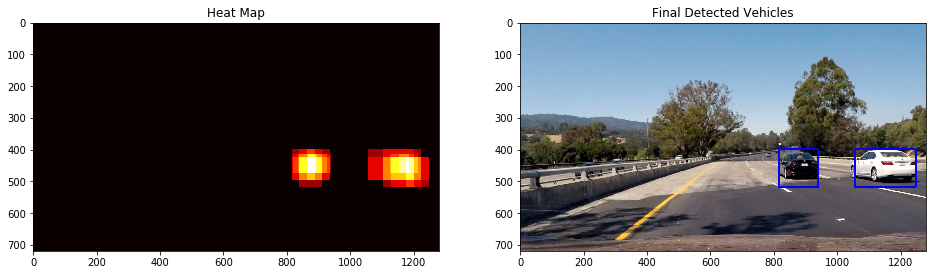

No of final boxes
2


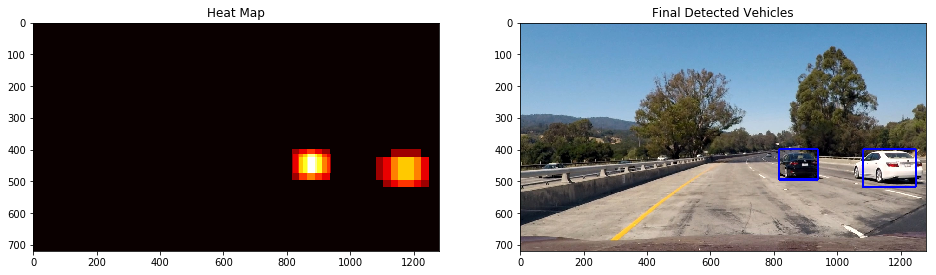

No of final boxes
1


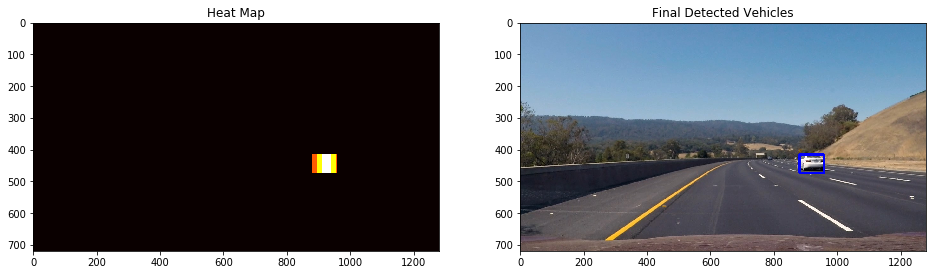

No of final boxes
0


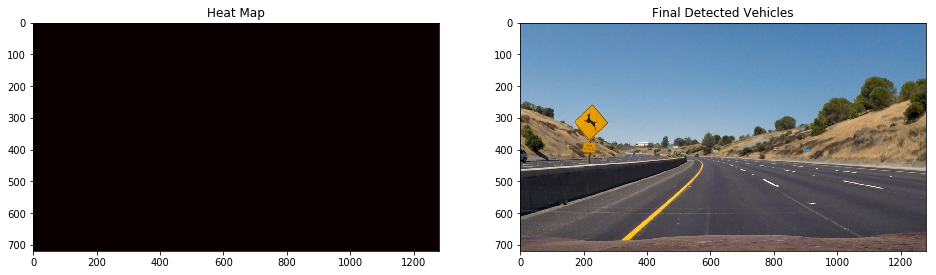

In [214]:
#Cell:15
from scipy.ndimage.measurements import label
images = glob.glob('./test_images/*.jpg')
for file in images:
    
    boxes[:] = []

    img = mpimg.imread(file)
   
    #For TestImage test3.jpg, following additional scale is required to detect the vehicle
    ystart = 400
    ystop = 700
    scale = 1.5
    out_img,boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins) 
    ystart = 416
    ystop = 480
    scale = 0.95
    out_img,boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins) 
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)

    heat = add_heat(heat,boxes)  
    
    #add current with previous average heat map
    #heat = heat + sumheat

    heat = apply_threshold(heat, 1)

    heatmap = np.clip(heat, 0, 255)

    labels = label(heatmap)
    print("No of final boxes")
    print(labels[1])
    
    draw_img= draw_labeled_bboxes(np.copy(img), labels)

    #saveLastheat(heat)  
    
    f,(ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
    ax2.imshow(draw_img)
    ax2.set_title('Final Detected Vehicles')
    ax1.imshow(heatmap, cmap='hot')
    ax1.set_title('Heat Map')
    fig.tight_layout()
    plt.show()

## Process Video

Step5: Identify vehicle position in the video with minimum false positive.
Step6: Explain filter implemented to combat false positive and combine overlapping boundary boxes.

In [201]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from scipy.ndimage.measurements import label

In [202]:
boxes=[]
    
def ProcessVideoFrames(img):     
    #For TestImage test3.jpg, following additional scale is required to detect the vehicle

    ystart = 400
    ystop = 700
    scale = 1.5
    out_img,boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins) 
    ystart = 416
    ystop = 480
    scale = 0.95
    out_img,boxes = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins) 

    #boxes = [item for sublist in boxes for item in sublist] 
    
    heatmap_img = np.zeros_like(img[:,:,0]).astype(np.float)
    heatmap_img = add_heat(heatmap_img, boxes)
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    boxes[:] = []
    
    return draw_img

In [203]:
white_output = './output_test_video.mp4'
clip1 = VideoFileClip("./test_video.mp4")
white_clip = clip1.fl_image(test_ProcessVideoFrames) 
#white_clip.write_videofile(white_output, audio=False)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output_test_video.mp4
[MoviePy] Writing video ./output_test_video.mp4



 97%|█████████▋| 38/39 [00:27<00:00,  1.39it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_test_video.mp4 

CPU times: user 26.4 s, sys: 897 ms, total: 27.3 s
Wall time: 27.8 s


In [204]:
white_output = './output_Project_video.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(test_ProcessVideoFrames) 
#white_clip.write_videofile(white_output, audio=False)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video ./output_Project_video_test.mp4
[MoviePy] Writing video ./output_Project_video_test.mp4



 24%|██▍       | 303/1261 [03:32<11:31,  1.39it/s]


 48%|████▊     | 605/1261 [06:55<07:19,  1.49it/s]


 72%|███████▏  | 907/1261 [10:30<04:06,  1.44it/s]


 96%|█████████▌| 1205/1261 [14:01<00:41,  1.35it/s]


100%|█████████▉| 1260/1261 [14:40<00:00,  1.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_Project_video_test.mp4 

CPU times: user 14min 23s, sys: 18.5 s, total: 14min 41s
Wall time: 14min 40s
